# Key-Value Attention for Thai Karaoke Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with attention mechnism that coverts names of Thai 2019 MP candidates from Thai script to Roman(Latin) script. E.g. นิยม-->niyom

The use of Pytorch Lightning is optional but recommended. You can use Pytorch if you prefer.

In [1]:
# !pip install lightning wandb
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [2]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# wandb_api_key = user_secrets.get_secret("wandb_api_key")

In [3]:
# !wandb login
# import wandb
# wandb.login(key=wandb_api_key)

In [4]:
%matplotlib inline
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')
import torch
# import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightning as L
import numpy as np

import random

## Load Dataset
We have generated a toy dataset using names of Thai MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

```
ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak
```


In [5]:
# !wget https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv

In [6]:
import csv

with open('mp_name_th_en.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    name_th = []
    name_en = []
    for row in readCSV:
        temp_th = row[0]
        temp_en = row[1]

        name_th.append(temp_th)
        name_en.append(temp_en)

In [7]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## TODO1: Preprocess dataset
* You will need 2 vocabularies (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding (for both input and output)
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)

In [8]:
#Preprocessing
input_chars = list(set(''.join(name_th)))
output_chars = list(set(''.join(name_en)))
data_size, vocab_size = len(name_th), len(input_chars)+1
output_vocab_size = len(output_chars)+2#+2 for special end of sentence token/PADDING
print('There are %d lines and %d unique characters in your input data.' % (data_size, vocab_size))
maxlen = len( max(name_th, key=len)) #max input length
maxlen_out = len( max(name_en, key=len)) #max input length

There are 10887 lines and 65 unique characters in your input data.


In [9]:
print("Max input length:", maxlen)
print("Max output length:", maxlen_out)

Max input length: 20
Max output length: 19


In [10]:
sorted_chars= sorted(input_chars)
sorted_output_chars= sorted(output_chars)
sorted_chars.insert(0,"<PAD>") #PADDING for input
sorted_output_chars.insert(0,"<PAD>") #PADDING for output
sorted_output_chars.insert(1,"</s>")

# Quick implementation of character tokenizer
# create a mapping from characters to integers
input_stoi = { ch:i for i,ch in enumerate(sorted_chars) }
input_itos = { i:ch for i,ch in enumerate(sorted_chars) }
input_encode = lambda s: [input_stoi[c] for c in s] # encoder: take a string, output a list of integers
input_decode = lambda l: ''.join([input_itos[i] for i in l]) # decoder: take a list of integers, output a string


output_stoi = { ch:i for i,ch in enumerate(sorted_output_chars) }
output_itos = { i:ch for i,ch in enumerate(sorted_output_chars) }
output_encode = lambda s: [output_stoi[c] for c in s] # encoder: take a string, output a list of integers
output_decode = lambda l: ''.join([output_itos[i] for i in l]) # decoder: take a list of integers, output a string

print(input_encode("ชนาธิป"))
print(input_decode(input_encode("ชนาธิป")))

[9, 24, 46, 23, 48, 26]
ชนาธิป


In [11]:
X = [torch.tensor(input_encode(list(name))) for name in name_th]
Y = [torch.tensor(output_encode(list(name))) for name in name_en]
X = nn.utils.rnn.pad_sequence(X, batch_first=True, padding_value=0)
Y = nn.utils.rnn.pad_sequence(Y, batch_first=True, padding_value=0)
print(X.shape)
print(Y.shape)

torch.Size([10887, 20])
torch.Size([10887, 19])


In [12]:
from torch.utils.data import Dataset, DataLoader

In [13]:
class NameDataset(Dataset):
  def __init__(self, X, y):
    self.encoded = X.long()
    self.label = y.long()

  def __getitem__(self, idx):
    return {"x" :self.encoded[idx], "y":self.label[idx]}

  def __len__(self):
    return len(self.encoded)

In [14]:
class NameDataModule(L.LightningDataModule):

  def __init__(self, train_data, y, batch_size, num_workers=0):
      super().__init__()
      self.train_data = train_data
      self.y = y
      self.batch_size = batch_size
      self.num_workers = num_workers


  def setup(self, stage: str):
    pass

  def collate_fn(self, batch):
    one_hot_x = torch.stack([F.one_hot(b["x"], num_classes=len(input_stoi)) for b in batch])
    return {"x": one_hot_x.float(), "y": torch.stack([b["y"] for b in batch])}

  def train_dataloader(self):
    train_dataset = NameDataset(self.train_data, self.y)
    train_loader = DataLoader(train_dataset,
                                batch_size = self.batch_size,
                                shuffle = True,
                                collate_fn = self.collate_fn,
                                num_workers = self.num_workers)
    return train_loader

# Attention Mechanism


## TODO 2: Code your own (key-value) attention mechnism
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* fill code for one_step_attention function



In [15]:
def one_step_attention(h, s_prev, linear_1, linear_2, ):

    #Split into Key-Value
    key, value = torch.split(h, h.size(-1)//2, dim=-1)
    #do concat with s_prev.
    s_prev = s_prev.unsqueeze(1).repeat((1, key.shape[1], 1))
    concat = torch.cat([key, s_prev], dim=-1) #concat.shape = batch, seq_len, hidden_dim*2
    #hint: you will need to use s_prev.repeat(...) somehow so that it has the same dimension as the key
    #hint2: s_prev.unsqueeze() could also be useful


    #Attention function###
    # use layer(s) from your model to calculate attention_scores and then softmax
    # calculate a context vector
    e = F.tanh(linear_1(concat))
    energies = F.relu(linear_2(e))
    attention_scores = F.softmax(energies, dim=1)
    context = torch.mul(attention_scores, value) # (batch, seq_len, value_dim=hidden_dim_enc/2)
    context = torch.sum(context, dim=1)
    return context, attention_scores

# Translation Model

## TODO3: Create and train your encoder/decoder model here

In [16]:
class AttentionModel(L.LightningModule):
    def __init__(
        self,
        learning_rate=0.01,
        criterion=nn.CrossEntropyLoss(),
    ):

        super().__init__()
        self.n_h = 32 #hidden dimensions for encoder
        self.n_s = 64 #hidden dimensions for decoder
        self.learning_rate = learning_rate
        self.criterion = criterion
        #encoder can be any RNN of your choice
        self.lstm = nn.LSTM(len(input_stoi), self.n_h, bidirectional=True, batch_first=True)
        #decoder has to be (any) RNNCell since we will need to calculate attention for each timestep manually
        self.decoder_lstm_cell = nn.LSTMCell(self.n_h, self.n_s)
        self.output_layer = nn.Linear(self.n_s, len(output_stoi))
        #attention
        self.fc1 = nn.Linear(self.n_h + self.n_s, self.n_h)
        self.fc2 = nn.Linear(self.n_h, 1)


    def forward(self, src, return_attention=False): #use return_attention only when you want to get the attention scores for visualizing
        #pass the input to the encoder
        lstm_out, _ = self.lstm(src)
        # print(lstm_out.shape)
        #Initialize the LSTM states. We have to do this since we are using LSTMCell (https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html)
        #These states will get updated while we are decoding
        decoder_s = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)
        decoder_c = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)

        #Iterate until max_output_length (Decoding)
        prediction = torch.zeros((src.shape[0], maxlen_out, len(output_stoi))).to(self.decoder_lstm_cell.weight_ih.device)
        attention_scores = [] #to store the score for each step
        for t in range(maxlen_out):

            #Perform one step of the attention mechanism to calculate the context vector at timestep t
            context, attention_score = one_step_attention(lstm_out, decoder_s, self.fc1, self.fc2)
            # print(context.shape, attention_score.shape)
            attention_scores.append(attention_score)
            # Feed the context vector to the decoder.
            decoder_s, decoder_c = self.decoder_lstm_cell(context, (decoder_s, decoder_c))
            # Pass the decoder hidden output to the output layer (softmax)
            out = self.output_layer(decoder_s)
            # Put the predicted output into the list for this timestep
            prediction[:, t] = out

        return (prediction, attention_scores if return_attention else None)

    def training_step(self, batch, batch_idx):
        src = batch['x']
        target = batch['y']
        prediction,_ = self(src)
        prediction = prediction.reshape(-1, len(output_stoi))
        target = target.reshape(-1)
        loss = self.criterion(prediction, target)
        self.log("train_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        src = batch['x']
        with torch.no_grad():
          prediction, attention_scores = self(src, return_attention=True)
          prediction = F.softmax(prediction, dim=-1)
          prediction = torch.argmax(prediction, dim=-1)
          for pred in prediction:
            # TODO:
            # print("".join(output_stoi.lookup_tokens(pred.cpu().numpy())))
            print("".join(output_decode(pred.cpu().numpy())))
        return prediction, attention_scores

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

In [17]:
model = AttentionModel(
    learning_rate=0.01,
    criterion=nn.CrossEntropyLoss()
)

In [18]:
batch_size = 2048
data_module = NameDataModule(X, Y, batch_size, num_workers=2)

In [19]:
from lightning import Trainer
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(project="hw3.1_attention", name="run3")

In [20]:
trainer = L.Trainer(
    max_epochs=500,
    logger=wandb_logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [22]:
# trainer.fit(model, data_module)
model = torch.load("att2048_500e.pth")
# model.load_state_dict(torch.load("att_1024.ckpt")['state_dict'])

In [51]:
# torch.save(model, "attention_1024.pth")

# Test Your Model

## TODO4: Test your model on 5 examples of your choice including your name!

Example Output:
```
prayutthatha</s></s>aa</s></s>a</s>
somchai</s></s></s></s>a</s></s>a</s></s></s></s></s>
thanathon</s></s></s></s></s></s></s></s></s></s></s>
newin</s>i</s></s></s></s></s></s></s></s></s></s></s></s></s>
suthep</s>he</s></s></s></s></s></s></s></s></s></s></s>
prawit</s></s></s></s></s></s></s></s></s></s></s></s></s></s>
chatchachatti</s></s>i</s></s></s></s>
```

<font color='blue'>Paste your model predictions in MyCourseVille</font>

In [23]:
EXAMPLES = ['ประยุทธ','สมชาย','ธนาธร','เนวิน','สุเทพ','ประวิตร์','ชัชชาติ']

In [24]:
model.eval()

AttentionModel(
  (criterion): CrossEntropyLoss()
  (lstm): LSTM(65, 32, batch_first=True, bidirectional=True)
  (decoder_lstm_cell): LSTMCell(32, 64)
  (output_layer): Linear(in_features=64, out_features=24, bias=True)
  (fc1): Linear(in_features=96, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [25]:
EXAMPLES.append('ชนาธิป')
predict_data = [torch.tensor(input_encode(name)) for name in EXAMPLES]
predict_data = nn.utils.rnn.pad_sequence(predict_data, batch_first=True, padding_value=0)

def collate_fn(batch, num_classes=len(input_stoi)):
    one_hot_x = torch.stack([F.one_hot(b["x"], num_classes=num_classes) for b in batch])
    return {"x": one_hot_x.float()}
predict_dataset = NameDataset(
    predict_data, torch.tensor([torch.tensor(0)] * len(predict_data))
)
predict_loader = DataLoader(
    predict_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=0
)

In [26]:
output = trainer.predict(model, predict_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: demonstem. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Tonza\anaconda3\envs\pattern\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

prayuttha<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
somchai<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
thanathon<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
newin<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
suthep<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
prawit<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
chatchachattii<PAD><PAD><PAD><PAD><PAD>
chonathip<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>


## TODO 5: Show your visualization of attention scores on one of your example

<font color='blue'>Paste your visualization image in MyCourseVille</font>

In [27]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
prediction, attention_scores = zip(*output)

In [33]:
sample_pred = prediction[-1]
sample_pred = [token for token in sample_pred.cpu().numpy().tolist()[-1] if token != 0]  # Remove padding tokens
sample_attention_scores = attention_scores[-1]
attn_viz = torch.stack(sample_attention_scores).squeeze().cpu().numpy()
attn_viz = attn_viz[:len(sample_pred), :len(EXAMPLES[-1])]
output_text = [char for char in output_decode(sample_pred)]
xlabels = [char for char in EXAMPLES[-1]]
assert attn_viz.shape[0] == len(output_text)
assert attn_viz.shape[1] == len(xlabels)

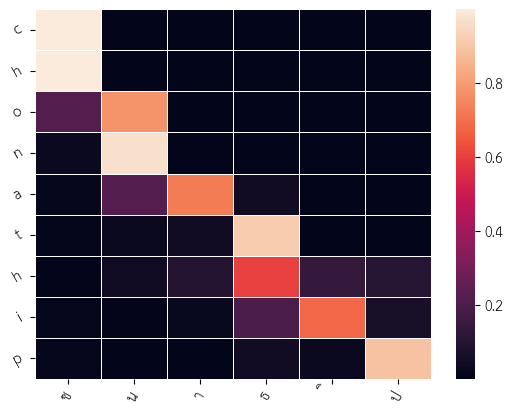

In [34]:
ax = sns.heatmap(attn_viz, linewidth=0.5)
ax.set_yticklabels(output_text,rotation=30)
ax.set_xticklabels(xlabels,rotation=60)
plt.savefig('viz.png')
plt.show()